<a href="https://colab.research.google.com/github/vigneswar96/vigneswar96/blob/main/DCGAN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN on MNIST 

## DCGAN is a Generative Adversarial Network (GAN) using CNN. 
- The dicriminator learns to discriminate real from fake images. 
- The genrator tries to fool the dicriminator by generating fake images. 
- The generator + discriminator form an adversarial network. 
- DCGAN trains the discriminator and adversairal networks alternatively. 

During training, not only the discriminator learns to distinguish real from fake images, it also coaches the genrator part of the Adversarial network on how to improve its ability to generate fake images. 


In [1]:
import tensorflow as tf 
import numpy as np 
import math 
import matplotlib.pyplot as plt 
import os 


## Building a Generator model 

Build a model using layers of BatchNorm- ReLU-Conv2DTranspose to generate fake images 

In [2]:
def build_generator(images_size=28, input_size=100):
  #Build an input layer 
  gen_input = tf.keras.layers.Input(shape=(input_size,))

  # Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer 
  x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)
  x = tf.keras.layers.Reshape((7 ,7 ,128))(x)

  # Use ConvTranspose
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)

  # Output layer for Generator 
  x = tf.keras.layers.Activation('sigmoid')(x)

  # Build model using Model API 
  generator = tf.keras.models. Model(gen_input, x, name='genrator')

  return generator 

## Building a Discriminator 

In [3]:
def build_discriminator(data_shape=[28,28,1,]):

  # Build the network 
  dis_input = tf.keras.layers.Input(data_shape)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(dis_input)
  x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides = 2, padding='same')(x)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(64, kernel_size= [5,5], strides= 2, padding ='same')(x)
  
  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size = [5,5], strides = 2, padding='same')(x)

  x = tf.keras.layers.LeakyReLU(alpha = 0.2)(x)
  x = tf.keras.layers.Conv2D(256, kernel_size = [5,5], strides = 1, padding='same')(x)

  # Flatten the output and build an output layer 
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1, activation ='sigmoid')(x)

  # Build Model 
  discriminator = tf.keras.models.Model(dis_input, x, name = 'discriminator')

  return discriminator 


## Building the Model for training 

In [4]:
def build_models():
  
  noise_size = 100
  learning_rate = 2e-4
  decay = 6e-8

  # Build Base Dicriminator model 
  base_discriminator = build_discriminator(data_shape= (28,28,1))

  # Define the optimizer ad compile model 
  discriminator = tf.keras.models.Model(inputs = base_discriminator.inputs,
                                        outputs = base_discriminator.outputs)
  optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate = learning_rate, decay=decay)
  discriminator.compile(loss = 'binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
  
  # Build Genrator model 
  generator = build_generator(images_size=28, input_size=noise_size)

  # Build Frozen Discriminator 
  frozen_discriminator = tf.keras.models.Model(inputs= base_discriminator.inputs,
                                               outputs = base_discriminator.outputs)
  # Freeze the weights of discriminator during adversarial training 
  frozen_discriminator.trainable = False 

  # Build Adversarial model 
  optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate*0.5, decay=decay *0.5)
  # Adversarial = generator + discriminator 
  adversarial = tf.keras.models.Model(generator.input,
                                      frozen_discriminator(generator.output))
  
  adversarial.compile(loss='binary_crossentropy',
                      optimizer = optimizer,
                      metrics = ['accuracy'])
  
  return generator, discriminator, adversarial 

## Training Discriminator and Adversarial Models 

In [5]:
def train_gan(generator, discriminator, adversarial, noise_size=100):

  #Training parameters 
  batch_size = 64
  train_steps = 10000
  image_size = 28

  # Load MNIST dataset 
  (train_x, _), (_,_) = tf.keras.datasets.mnist.load_data()
  # Make it 3D dataset 
  train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
  # Standardize data : 0to 1
  train_x = train_x.astype('float32') /255

  # Input for testing generator at different intervals, we will generate 16 images
  test_noise_input = np.random.uniform(-1.0,1.0, size= [16, noise_size])

  # Start training 
  for i in range(train_steps):

    # Train Dicriminator 

    # 1. Get fake images from generator 
    noise_input = np.random.uniform(-1.0, 1.0, size = [batch_size, noise_size])
    fake_images = generator.predict(noise_input)

    # 2. Get real images from training set 
    img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
    real_images = train_x[img_indexes]

    # 3. Prepare input for training Discriminator 
    X = np.concatenate((real_images, fake_images))

    # 4. Labels for training 
    y_real = np.ones((batch_size,1))
    y_fake = np.zeros((batch_size,1))
    y = np.concatenate((y_real, y_fake))

    # 5. Train Discriminator 
    d_loss, d_acc = discriminator.train_on_batch(X,y)

    # Train Adversarial Network 

    # 1. Prepare input - create a new batch of noise 
    X = noise_input = np.random.uniform(-1.0,1.0,size = [batch_size, noise_size])

    # 2. Prepare labels - training Adversairal network to lie :) - All 1s 
    y = np.ones((batch_size,1))

    # 3. Train - Pls note Discriminator is not getting trained here 
    a_loss, a_acc = adversarial.train_on_batch(X,y)

    if i % 100 == 0:
      # Print loss and Accuracy for both networks 
      print ("%s [Discriminator loss:%f,acc : %f, Adversarial loss: %f, acc: %f])" % (i, d_loss, d_acc, a_loss, a_acc))

    # Save generated images to see how well Generator is doing 
    if (i+1) % 500 ==0:

      # Generate 16 images 
      fake_images = generator.predict(test_noise_input)

      # Display images 
      plot_images(fake_images, i+1)

      # SAve Genrator model 
    generator.save('mnist_generator_dcgan.h5')


## Save generator images 

In [6]:
def plot_images(fake_images, step):

  plt.figure(figsize=(2.5,2.5))
  num_images = fake_images.shape[0]

  image_size = fake_images.shape[1]
  rows = int(math.sqrt(fake_images.shape[0]))

  for i in range(num_images):
    plt.subplot(rows, rows, i+1)
    image = np.reshape(fake_images[i], [image_size, image_size])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  plt.show()


### Train GAN Training 


In [7]:
G, D, A = build_models()

In [8]:
G.summary()

Model: "genrator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                  

In [9]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928

In [10]:
A.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                   

2/2 [==============================] - 4s 11ms/step


0 [Discriminator loss:0.695737,acc : 0.414062, Adversarial loss: 1.007977, acc: 0.000000])
2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


100 [Discriminator loss:0.000022,acc : 1.000000, Adversarial loss: 0.001353, acc: 1.000000])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


200 [Discriminator loss:0.000021,acc : 1.000000, Adversarial loss: 0.000182, acc: 1.000000])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


300 [Discriminator loss:0.000028,acc : 1.000000, Adversarial loss: 0.000001, acc: 1.000000])
2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


400 [Discriminator loss:1.240550,acc : 0.789062, Adversarial loss: 0.000001, acc: 1.000000])
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 318ms/step


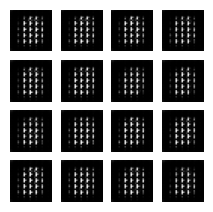

2/2 [==============================] - 0s 7ms/step


500 [Discriminator loss:0.923698,acc : 0.500000, Adversarial loss: 5.155614, acc: 0.000000])
2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


600 [Discriminator loss:0.305888,acc : 0.875000, Adversarial loss: 4.022345, acc: 0.000000])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


700 [Discriminator loss:0.350080,acc : 0.843750, Adversarial loss: 0.582324, acc: 0.703125])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


800 [Discriminator loss:0.400591,acc : 0.804688, Adversarial loss: 1.179113, acc: 0.218750])
2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


900 [Discriminator loss:0.620524,acc : 0.671875, Adversarial loss: 0.493983, acc: 0.828125])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 19ms/step


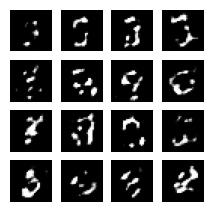

2/2 [==============================] - 0s 5ms/step


1000 [Discriminator loss:0.394117,acc : 0.859375, Adversarial loss: 0.553683, acc: 0.734375])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


1100 [Discriminator loss:0.502043,acc : 0.718750, Adversarial loss: 0.687520, acc: 0.609375])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


1200 [Discriminator loss:0.514455,acc : 0.695312, Adversarial loss: 0.969990, acc: 0.296875])
2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


1300 [Discriminator loss:0.516507,acc : 0.726562, Adversarial loss: 0.926652, acc: 0.390625])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


1400 [Discriminator loss:0.511665,acc : 0.757812, Adversarial loss: 1.175843, acc: 0.171875])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 21ms/step


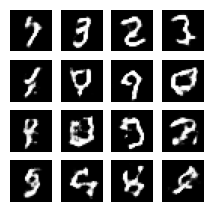

2/2 [==============================] - 0s 7ms/step


1500 [Discriminator loss:0.477577,acc : 0.796875, Adversarial loss: 1.211806, acc: 0.171875])
2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


1600 [Discriminator loss:0.557340,acc : 0.679688, Adversarial loss: 0.943275, acc: 0.265625])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 21ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


1700 [Discriminator loss:0.536114,acc : 0.726562, Adversarial loss: 1.081926, acc: 0.265625])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


1800 [Discriminator loss:0.465239,acc : 0.757812, Adversarial loss: 1.554252, acc: 0.156250])
2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 7ms/step


1900 [Discriminator loss:0.458188,acc : 0.796875, Adversarial loss: 1.455157, acc: 0.140625])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 20ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 23ms/step


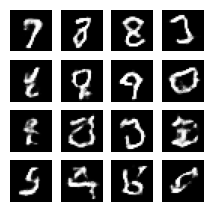

2/2 [==============================] - 0s 11ms/step


2000 [Discriminator loss:0.525595,acc : 0.789062, Adversarial loss: 1.485743, acc: 0.140625])
2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2100 [Discriminator loss:0.455412,acc : 0.812500, Adversarial loss: 1.402265, acc: 0.203125])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2200 [Discriminator loss:0.469612,acc : 0.796875, Adversarial loss: 1.489249, acc: 0.140625])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2300 [Discriminator loss:0.507568,acc : 0.742188, Adversarial loss: 1.339741, acc: 0.171875])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2400 [Discriminator loss:0.418676,acc : 0.828125, Adversarial loss: 1.024428, acc: 0.343750])
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 20ms/step


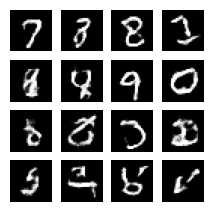

2/2 [==============================] - 0s 6ms/step


2500 [Discriminator loss:0.479805,acc : 0.804688, Adversarial loss: 1.408910, acc: 0.171875])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2600 [Discriminator loss:0.493499,acc : 0.812500, Adversarial loss: 1.073090, acc: 0.375000])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2700 [Discriminator loss:0.607913,acc : 0.718750, Adversarial loss: 1.281168, acc: 0.171875])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 21ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2800 [Discriminator loss:0.523940,acc : 0.679688, Adversarial loss: 1.591539, acc: 0.125000])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2900 [Discriminator loss:0.473963,acc : 0.765625, Adversarial loss: 1.743407, acc: 0.093750])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


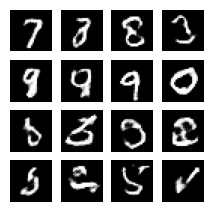

2/2 [==============================] - 0s 15ms/step


3000 [Discriminator loss:0.476826,acc : 0.757812, Adversarial loss: 1.350127, acc: 0.187500])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


3100 [Discriminator loss:0.550681,acc : 0.679688, Adversarial loss: 1.162088, acc: 0.296875])
2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


3200 [Discriminator loss:0.557891,acc : 0.734375, Adversarial loss: 0.905450, acc: 0.437500])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


3300 [Discriminator loss:0.523288,acc : 0.742188, Adversarial loss: 0.868680, acc: 0.406250])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


3400 [Discriminator loss:0.531675,acc : 0.765625, Adversarial loss: 1.180058, acc: 0.265625])
2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


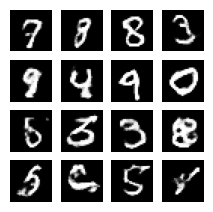

2/2 [==============================] - 0s 6ms/step


3500 [Discriminator loss:0.435328,acc : 0.812500, Adversarial loss: 1.341258, acc: 0.203125])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


3600 [Discriminator loss:0.446273,acc : 0.796875, Adversarial loss: 1.420763, acc: 0.171875])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


3700 [Discriminator loss:0.557135,acc : 0.695312, Adversarial loss: 1.190000, acc: 0.328125])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


3800 [Discriminator loss:0.543667,acc : 0.726562, Adversarial loss: 1.294099, acc: 0.171875])
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 8ms/step


3900 [Discriminator loss:0.468938,acc : 0.765625, Adversarial loss: 1.575046, acc: 0.140625])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 21ms/step


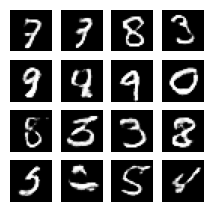

2/2 [==============================] - 0s 6ms/step


4000 [Discriminator loss:0.465547,acc : 0.804688, Adversarial loss: 1.307790, acc: 0.171875])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 22ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


4100 [Discriminator loss:0.666320,acc : 0.695312, Adversarial loss: 0.904613, acc: 0.406250])
2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


4200 [Discriminator loss:0.550063,acc : 0.750000, Adversarial loss: 1.271899, acc: 0.203125])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


4300 [Discriminator loss:0.621349,acc : 0.726562, Adversarial loss: 2.162690, acc: 0.093750])
2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


4400 [Discriminator loss:0.432372,acc : 0.804688, Adversarial loss: 1.249139, acc: 0.250000])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 35ms/step


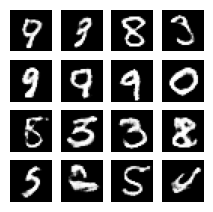

2/2 [==============================] - 0s 7ms/step


4500 [Discriminator loss:0.561103,acc : 0.726562, Adversarial loss: 1.542813, acc: 0.109375])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


4600 [Discriminator loss:0.455294,acc : 0.820312, Adversarial loss: 1.637689, acc: 0.093750])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


4700 [Discriminator loss:0.506685,acc : 0.781250, Adversarial loss: 1.044983, acc: 0.250000])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


4800 [Discriminator loss:0.724542,acc : 0.609375, Adversarial loss: 1.501725, acc: 0.125000])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


4900 [Discriminator loss:0.463207,acc : 0.773438, Adversarial loss: 1.215314, acc: 0.234375])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 29ms/step


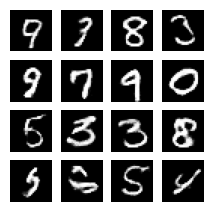

2/2 [==============================] - 0s 7ms/step


5000 [Discriminator loss:0.502313,acc : 0.773438, Adversarial loss: 1.108755, acc: 0.281250])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


5100 [Discriminator loss:0.552072,acc : 0.726562, Adversarial loss: 1.184250, acc: 0.296875])
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


5200 [Discriminator loss:0.555419,acc : 0.679688, Adversarial loss: 1.229477, acc: 0.218750])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


5300 [Discriminator loss:0.551795,acc : 0.695312, Adversarial loss: 1.335745, acc: 0.187500])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


5400 [Discriminator loss:0.519572,acc : 0.742188, Adversarial loss: 1.241573, acc: 0.203125])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 26ms/step


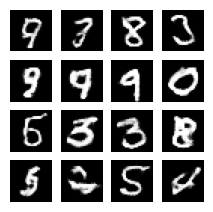

2/2 [==============================] - 0s 8ms/step


5500 [Discriminator loss:0.541938,acc : 0.718750, Adversarial loss: 1.141709, acc: 0.250000])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


5600 [Discriminator loss:0.619861,acc : 0.695312, Adversarial loss: 1.563798, acc: 0.109375])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 15ms/step


5700 [Discriminator loss:0.462591,acc : 0.773438, Adversarial loss: 1.432627, acc: 0.125000])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


5800 [Discriminator loss:0.519078,acc : 0.757812, Adversarial loss: 1.244022, acc: 0.187500])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


5900 [Discriminator loss:0.520734,acc : 0.742188, Adversarial loss: 1.147393, acc: 0.250000])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 46ms/step


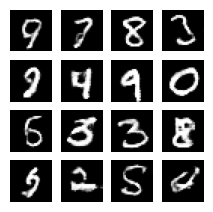

2/2 [==============================] - 0s 6ms/step


6000 [Discriminator loss:0.572186,acc : 0.679688, Adversarial loss: 1.471135, acc: 0.156250])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


6100 [Discriminator loss:0.523307,acc : 0.687500, Adversarial loss: 1.427178, acc: 0.187500])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


6200 [Discriminator loss:0.478468,acc : 0.812500, Adversarial loss: 1.210868, acc: 0.234375])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


6300 [Discriminator loss:0.500931,acc : 0.734375, Adversarial loss: 1.039562, acc: 0.406250])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


6400 [Discriminator loss:0.565074,acc : 0.671875, Adversarial loss: 1.407567, acc: 0.109375])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 40ms/step


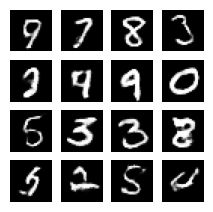

2/2 [==============================] - 0s 5ms/step


6500 [Discriminator loss:0.523389,acc : 0.742188, Adversarial loss: 1.487259, acc: 0.171875])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


6600 [Discriminator loss:0.549271,acc : 0.671875, Adversarial loss: 1.003833, acc: 0.250000])
2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


6700 [Discriminator loss:0.489083,acc : 0.765625, Adversarial loss: 1.349754, acc: 0.140625])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


6800 [Discriminator loss:0.558427,acc : 0.703125, Adversarial loss: 0.748301, acc: 0.593750])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


6900 [Discriminator loss:0.526261,acc : 0.710938, Adversarial loss: 0.969791, acc: 0.406250])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 29ms/step


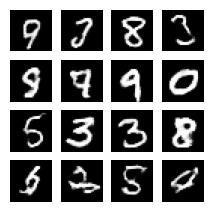

2/2 [==============================] - 0s 5ms/step


7000 [Discriminator loss:0.552211,acc : 0.695312, Adversarial loss: 1.137709, acc: 0.328125])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


7100 [Discriminator loss:0.551453,acc : 0.703125, Adversarial loss: 1.417346, acc: 0.171875])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


7200 [Discriminator loss:0.522782,acc : 0.726562, Adversarial loss: 1.310196, acc: 0.218750])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


7300 [Discriminator loss:0.450735,acc : 0.820312, Adversarial loss: 1.261629, acc: 0.218750])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


7400 [Discriminator loss:0.506751,acc : 0.710938, Adversarial loss: 1.356145, acc: 0.140625])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 19ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 57ms/step


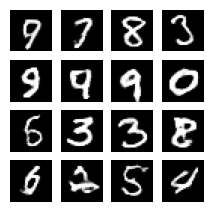

2/2 [==============================] - 0s 10ms/step


7500 [Discriminator loss:0.486085,acc : 0.789062, Adversarial loss: 0.916254, acc: 0.359375])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


7600 [Discriminator loss:0.569249,acc : 0.679688, Adversarial loss: 1.436519, acc: 0.109375])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


7700 [Discriminator loss:0.541386,acc : 0.656250, Adversarial loss: 1.238691, acc: 0.203125])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


7800 [Discriminator loss:0.481197,acc : 0.773438, Adversarial loss: 1.143390, acc: 0.234375])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 22ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


7900 [Discriminator loss:0.605090,acc : 0.726562, Adversarial loss: 1.189858, acc: 0.234375])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 40ms/step


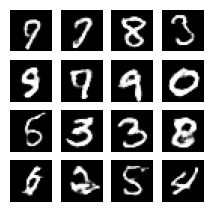

2/2 [==============================] - 0s 7ms/step


8000 [Discriminator loss:0.550171,acc : 0.750000, Adversarial loss: 1.047801, acc: 0.296875])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


8100 [Discriminator loss:0.554281,acc : 0.718750, Adversarial loss: 1.335438, acc: 0.140625])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


8200 [Discriminator loss:0.596153,acc : 0.679688, Adversarial loss: 1.273184, acc: 0.156250])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


8300 [Discriminator loss:0.540044,acc : 0.695312, Adversarial loss: 1.339763, acc: 0.203125])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 20ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


8400 [Discriminator loss:0.664263,acc : 0.640625, Adversarial loss: 1.527208, acc: 0.093750])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 38ms/step


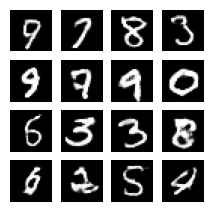

2/2 [==============================] - 0s 5ms/step


8500 [Discriminator loss:0.502396,acc : 0.796875, Adversarial loss: 1.157324, acc: 0.171875])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


8600 [Discriminator loss:0.524516,acc : 0.726562, Adversarial loss: 1.039296, acc: 0.343750])
2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


8700 [Discriminator loss:0.500553,acc : 0.757812, Adversarial loss: 1.153530, acc: 0.296875])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 16ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


8800 [Discriminator loss:0.556773,acc : 0.718750, Adversarial loss: 1.129032, acc: 0.234375])
2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 17ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


8900 [Discriminator loss:0.540170,acc : 0.718750, Adversarial loss: 1.135813, acc: 0.265625])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 27ms/step


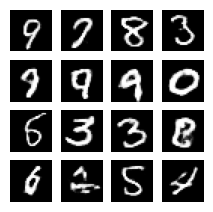

2/2 [==============================] - 0s 6ms/step


9000 [Discriminator loss:0.517735,acc : 0.765625, Adversarial loss: 1.187235, acc: 0.203125])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


9100 [Discriminator loss:0.533051,acc : 0.687500, Adversarial loss: 1.508940, acc: 0.125000])
2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


9200 [Discriminator loss:0.508584,acc : 0.796875, Adversarial loss: 1.116992, acc: 0.218750])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


9300 [Discriminator loss:0.593496,acc : 0.687500, Adversarial loss: 1.239282, acc: 0.234375])
2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


9400 [Discriminator loss:0.584302,acc : 0.710938, Adversarial loss: 1.307262, acc: 0.218750])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 28ms/step


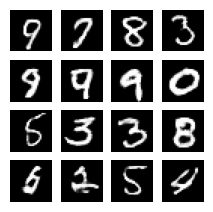

2/2 [==============================] - 0s 7ms/step


9500 [Discriminator loss:0.534898,acc : 0.742188, Adversarial loss: 1.268816, acc: 0.218750])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


9600 [Discriminator loss:0.493329,acc : 0.750000, Adversarial loss: 1.131609, acc: 0.359375])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


9700 [Discriminator loss:0.549965,acc : 0.671875, Adversarial loss: 1.259323, acc: 0.203125])
2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 14ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


9800 [Discriminator loss:0.575246,acc : 0.695312, Adversarial loss: 1.425722, acc: 0.125000])
2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 12ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


9900 [Discriminator loss:0.530000,acc : 0.726562, Adversarial loss: 1.408307, acc: 0.187500])
2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 9ms/step


2/2 [==============================] - 0s 11ms/step


2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 29ms/step


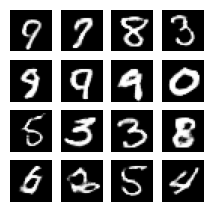

In [11]:
train_gan(G,D,A)